SPEED LAYER : S3 + Lambda + Firehose + Elasticsearch Service + Kibana + Kinesis Data Analytics
===

___
** /!\ You will have to update empty env variables /!\ **
___

**1. Create the bucket that will receive your files**


In [ ]:
!aws s3api create-bucket --bucket $USER-$WORKSHOP-potus-coming --region eu-west-1 \
--create-bucket-configuration LocationConstraint=eu-west-1 

** 2. Create the lambda function used to stream data received on S3 **


- Before creating the lambda function, it is mandatory to create a role for this lambda function. There are 2 steps to assign a role to a specific service : 
    - Create a policy that will allow the service to assume a role
    - Create the policy attached to the role

** 2.a Create the policy that will allow our lambda to assume a role **

In [ ]:
%%bash
echo """{
  \"Version\":\"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Principal\": {
        \"Service\": \"lambda.amazonaws.com\"
      },
      \"Action\": \"sts:AssumeRole\"
    }
  ]
}">assumerole-lambda-policy.json

** 2.b Create an Inline policy for this lambda function (S3 Get  + S3 List) **

In [ ]:
%%bash
echo "{
  \"Version\": \"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Action\": [
        \"s3:Get*\",
        \"s3:List*\"
      ],
      \"Resource\": \"arn:aws:s3:::*\"
    }
  ]
}">s3-read-policy.json

** 2.c Create the role associated to the lambda : **

In [ ]:
!aws iam create-role --role-name $USER-$WORKSHOP-role-lambda-speedlayer --assume-role-policy-document file://assumerole-lambda-policy.json

Attached the ** inline ** s3-read-policy to the role

In [ ]:
!aws iam put-role-policy --role-name $USER-$WORKSHOP-role-lambda-speedlayer --policy-name $USER-$WORKSHOP-lambda-s3-r \
  --policy-document file://s3-read-policy.json

Attach 2 **managed** policies to the role : 
- AWS Lambda Basic Execution
- AWS Amazon Kinesis Firehose Full Access

** Lambda Basic Execution **
```javascript
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Action": [
        "logs:CreateLogGroup",
        "logs:CreateLogStream",
        "logs:PutLogEvents"
      ],
      "Resource": "*"
    }
  ]
}```

** Amazon Kinesis Firehose Full Access **
```javascript
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Action": [
                "firehose:*"
            ],
            "Effect": "Allow",
            "Resource": "*"
        }
    ]
}```


In [ ]:
!aws iam attach-role-policy --role-name $USER-$WORKSHOP-role-lambda-speedlayer \
--policy-arn arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole

In [ ]:
!aws iam attach-role-policy --role-name $USER-$WORKSHOP-role-lambda-speedlayer \
--policy-arn arn:aws:iam::aws:policy/AmazonKinesisFirehoseFullAccess

** 2.d Create lambda function with the following parameters **
    - Name : $USER-$WORKSHOP-speedlayer
    - runtime : nodejs6.10
    - role : $USER-$WORKSHOP-role-lambda-speedlayer
    - handler : $USER-$WORKSHOP-function.handler
    - code : S3 source
    - environment : Variable d'env DELIVERY_STREAM_NAME
    - region
    


```javascript
//START
'use strict';

console.log('Loading function');

const aws = require('aws-sdk');
const firehose = new aws.Firehose();
const s3 = new aws.S3({ apiVersion: '2006-03-01' });

function sendToFirehose(recordsForFirehose){
    var paramsFirehose = {
        DeliveryStreamName: process.env.DELIVERY_STREAM_NAME, // required
        Records: recordsForFirehose
    };
    console.log(recordsForFirehose);
    firehose.putRecordBatch(paramsFirehose, function(err, data) {
        if (err) console.log(err, err.stack); // an error occurred
        else     console.log(data);           // successful response
    });
}

function manageData(csvData){
    var recordsForFirehose = new Array();
    var lines = csvData.split("\n"); 
    var i = 0 ;
    var errors = 0 ;
    lines.forEach(function(line) {
        if (line!==""){
            try{
                var fields = line.split("|");
                var isoDate = null ;
                isoDate = new Date(fields[4]).toISOString() ;  
                var recordForFirehose = {
                    id : fields[0],
                    name : fields[1],
                    text : fields[2],
                    date: isoDate,
                    isodate: fields[4],
                    time: fields[3]
                };
                recordsForFirehose[i] = {Data:JSON.stringify(recordForFirehose)} ;
                i++;
            }catch(e){
                errors++;
            }
        }
    });
    console.log("errors:"+errors);
    sendToFirehose(recordsForFirehose)

}

exports.handler = (event, context, callback) => {
    //console.log('Received event:', JSON.stringify(event, null, 2));

    // Get the object from the event and show its content type
    const bucket = event.Records[0].s3.bucket.name;
    const key = decodeURIComponent(event.Records[0].s3.object.key.replace(/\+/g, ' '));
    const params = {
        Bucket: bucket,
        Key: key,
    };
    s3.getObject(params, (err, data) => {
        if (err) {
            console.log(err);
            const message = `Error getting object ${key} from bucket ${bucket}. Make sure they exist and your bucket is in the same region as this function.`;
            console.log(message);
            callback(message);
        } else {
            console.log('CONTENT TYPE:', data.ContentType);
            manageData(data.Body.toString('ascii'));
            callback(null, data.ContentType);
        }
    });
};
//END
```

In [ ]:
!aws lambda create-function --function-name $USER-$WORKSHOP-speedlayer \
--runtime nodejs6.10 --role arn:aws:iam::$ACCOUNTID:role/$USER-$WORKSHOP-role-lambda-speedlayer \
--handler speedlayer-function.handler --code S3Bucket=aws-potus-eu-west-1,S3Key=jupyter/speedlayer-function.zip \
--environment Variables="{DELIVERY_STREAM_NAME=$USER-$WORKSHOP-potus-ds-clinton}" --region eu-west-1

** 2.e Invoke Lambda function when objects are added to s3 **

In [ ]:
!aws lambda add-permission --function-name $USER-$WORKSHOP-speedlayer --region eu-west-1 --statement-id 123456780-$USER-$WORKSHOP \
--action "lambda:InvokeFunction" --principal s3.amazonaws.com \
--source-arn arn:aws:s3:::$USER-$WORKSHOP-potus-coming --source-account $ACCOUNTID

Configure the event that will trigger the lambda function on the bucket S3 

In [ ]:
%%bash
echo "{
    \"LambdaFunctionConfigurations\": [
        {
            \"LambdaFunctionArn\": \"arn:aws:lambda:eu-west-1:$ACCOUNTID:function:$USER-$WORKSHOP-speedlayer\",
            \"Events\": [
                \"s3:ObjectCreated:*\"
            ],
            \"Filter\": {
             \"Key\": {
              \"FilterRules\":[
                {
                 \"Name\": \"prefix\",
                 \"Value\": \"clinton/\"
                }
               ]
              }
             }
        }
    ]
}">s3-trigger-lambda.json

In [ ]:
!aws s3api put-bucket-notification-configuration --bucket $USER-$WORKSHOP-potus-coming \
--notification-configuration file://s3-trigger-lambda.json

The lambda function will now be triggered each time an object is added to the bucket \$USER-\$WORKSHOP-potus-coming

** 3. ElasticSearch Cluster Creation **


In [ ]:
!aws es create-elasticsearch-domain --domain-name $USER-$WORKSHOP-potus --elasticsearch-version 5.1 \
  --elasticsearch-cluster-config  InstanceType=m3.large.elasticsearch,InstanceCount=1 \
  --ebs-options EBSEnabled=true,VolumeType=gp2,VolumeSize=160 --region eu-west-1

You will need to push a policy to update the access policy in order to be able to access ES and Kibana from your IP.
To get your IP address : https://www.google.fr/search?hl=en&safe=off&q=what+is+my+ip 

***Don't forget to change PUBLICIP in the cell below in the form www.xxx.yyy.zzz.*** 

In [ ]:
%env MY_IP=

In [ ]:
%%bash
echo "{
  \"Version\": \"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Principal\": \"*\",
      \"Action\": \"es:ESHttp*\",
      \"Resource\": \"arn:aws:es:eu-west-1:$ACCOUNTID:domain/$USER-$WORKSHOP-potus/*\",
      \"Condition\": {
        \"IpAddress\": {
          \"aws:SourceIp\": \"$MY_IP/32\"
        }
      }
    }
  ]
}">es-access-policy.json

In [ ]:
!aws es update-elasticsearch-domain-config --region eu-west-1 \
 --domain-name $USER-$WORKSHOP-potus \
    --access-policies file://es-access-policy.json

You can review you cluster with the following command

In [ ]:
!aws es describe-elasticsearch-domain --domain $USER-$WORKSHOP-potus --region eu-west-1

**4. Create the Kinesis Firehose**

As previously done for the lambda function, before creating a service (here firehose) we need to create a role associated to this service. This is done in 4 steps : 

- Create a policy allowing the firehose to assume a role
- Create a policy for the role (Inline policy)
- Create a role
- Attach the Inline policy to the role
-

In [ ]:
%%bash
echo """{
  \"Version\":\"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Principal\": {
        \"Service\": \"firehose.amazonaws.com\"
      },
      \"Action\": \"sts:AssumeRole\"
    }
  ]
}">assumerole-firehose-policy.json

In [ ]:
%%bash
echo "{
  \"Version\": \"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Action\": [
        \"s3:*\",
        \"es:*\"
      ],
      \"Resource\": \"*\"
    }
  ]
}">es-policy.json

In [ ]:
!aws iam create-role --role-name $USER-$WORKSHOP-role-firehose-speedlayer --assume-role-policy-document \
file://assumerole-firehose-policy.json

In [ ]:
!aws iam put-role-policy --role-name $USER-$WORKSHOP-role-firehose-speedlayer --policy-name es-policy \
  --policy-document file://es-policy.json

** Now we create the firehose delivery stream **

In [ ]:
%%bash
echo "{
  \"RoleARN\": \"arn:aws:iam::$ACCOUNTID:role/$USER-$WORKSHOP-role-firehose-speedlayer\",
  \"DomainARN\": \"arn:aws:es:eu-west-1:$ACCOUNT:domain/$USER-$WORKSHOP-potus\",
  \"IndexName\": \"clinton\",
  \"TypeName\": \"message\",
  \"BufferingHints\": {
    \"IntervalInSeconds\": 60,
    \"SizeInMBs\": 5
  },
  \"IndexRotationPeriod\": \"NoRotation\",
  \"RetryOptions\": {
    \"DurationInSeconds\": 300
  },
  \"S3BackupMode\": \"FailedDocumentsOnly\",
  \"S3Configuration\": {
    \"RoleARN\": \"arn:aws:iam::$ACCOUNTID:role/$USER-$WORKSHOP-role-firehose-speedlayer\",
    \"BucketARN\": \"arn:aws:s3:::$USER-$WORKSHOP-potus-coming\"
    }
}">firehose2ES-configuration.json

In [ ]:
!aws firehose create-delivery-stream --delivery-stream-name $USER-$WORKSHOP-potus-ds-clinton \
--delivery-stream-type DirectPut --elasticsearch-destination-configuration file://firehose2ES-configuration.json \
--region eu-west-1

___
***Please wait your Elasticsearch Service Cluster to be ready.*** Configuration state should be **ACTIVE**

To monitor that please look at https://eu-west-1.console.aws.amazon.com/es/home?region=eu-west-1
___


# Option 4bis: Kinesis Data Analytics -------------------------------- 
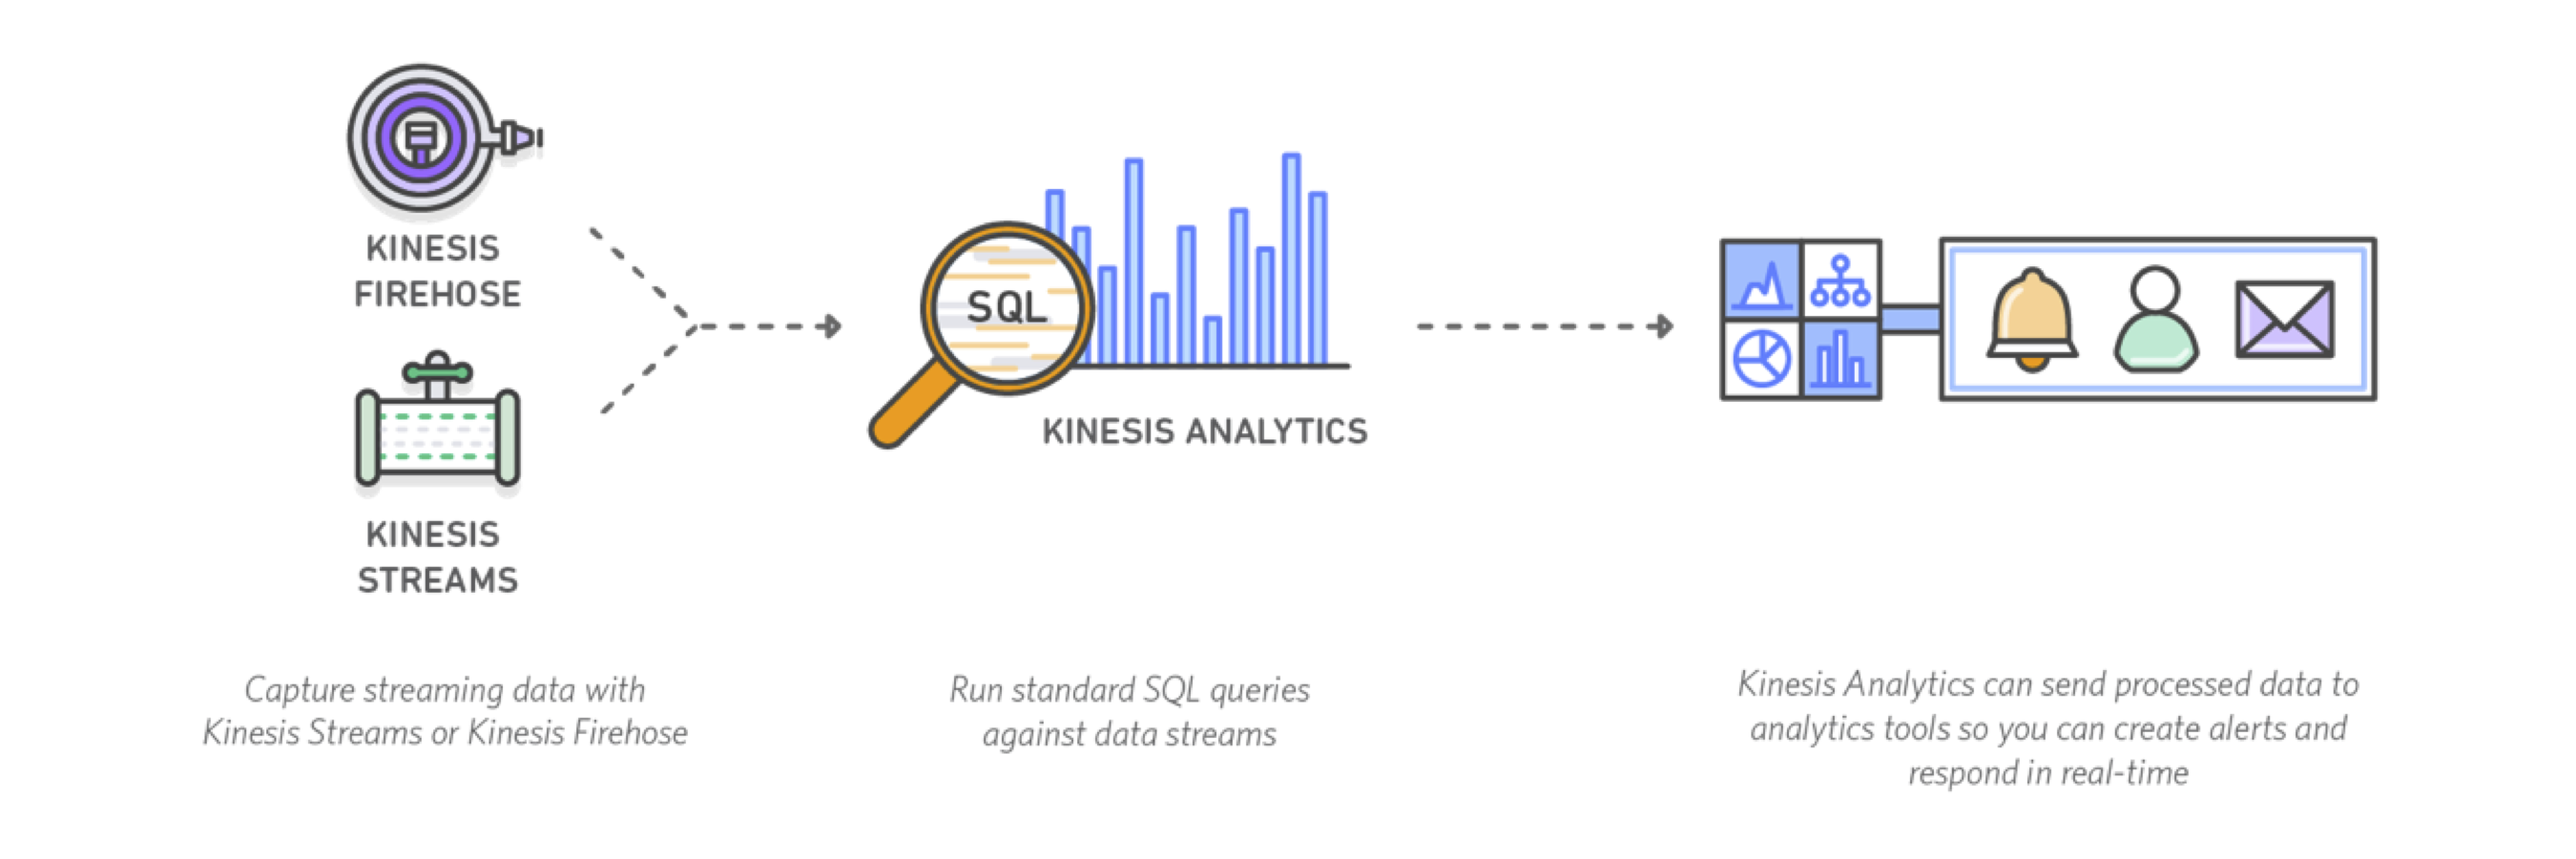
This section is **optional**. You need to have created all previous ressources (kinesis firehose, lambda function) except Elastic Search which is not mandatory. You will use §5a and §5b to send potus clinton tweets flying data to firehose. This data will then be analysed by Kinesis Data Analytics to determine the top 5 tweeters with a tumbling window. Kinesis Data Analytics will then send those results to a Lambda function that will copy them in a DynamoDB table.


** 4bis.a Create the lambda function that will be used to copy Kinesis Data Analytics output in DynamoDB **


- Before creating the lambda function, it is mandatory to create a role for this lambda function. There are 2 steps to assign a role to a specific service : 
    - Create a policy that will allow the service to assume a role
    - Create the policy attached to the role

*** 4bis.a.1 Create the policy that will allow our lambda to assume a role ***

In [ ]:
%%bash
echo """{
  \"Version\":\"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Principal\": {
        \"Service\": \"lambda.amazonaws.com\"
      },
      \"Action\": \"sts:AssumeRole\"
    }
  ]
}">assumerole-lambda-policy.json

*** 4bis.a.2 Create the role associated to the lambda ***

In [ ]:
!aws iam create-role --role-name $USER-$WORKSHOP-role-lambda-ka-speedlayer \
--assume-role-policy-document file://assumerole-lambda-policy.json

***4bis.a.3 Attach a managed policy to the role: AWS Lambda Basic Execution ***

Lambda Basic Execution managed policy
```javascript
{
  "Version": "2012-10-17",
  "Statement": [
    {
      "Effect": "Allow",
      "Action": [
        "logs:CreateLogGroup",
        "logs:CreateLogStream",
        "logs:PutLogEvents"
      ],
      "Resource": "*"
    }
  ]
}
```

In [ ]:
!aws iam attach-role-policy --role-name $USER-$WORKSHOP-role-lambda-ka-speedlayer \
--policy-arn arn:aws:iam::aws:policy/service-role/AWSLambdaBasicExecutionRole

*** 4bis.a.4 Create DynamoDB access policy and add it to the role ***

In [ ]:
%%bash
echo "{
  \"Version\": \"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Action\": [
        \"dynamodb:*\"
      ],
      \"Resource\": \"arn:aws:dynamodb:eu-west-1:$ACCOUNTID:table/*\"
    }
  ]
}">ka-lambda-policy.json

In [ ]:
!aws iam put-role-policy --role-name $USER-$WORKSHOP-role-lambda-ka-speedlayer --policy-name ka-policy \
  --policy-document file://ka-lambda-policy.json

*** 4bis.a.5 Create lambda function with the following parameters ***

* Name: \$USER-\$WORKSHOP-ka-output-speedlayer
* runtime: python 2.7
* role: \$USER-\$WORKSHOP-role-lambda-ka-speedlayer
* handler: lambda_handler
* code: S3 source
* environment: Variable d'env DDB_TABLE_NAME
* Dynamo DB table name: \$USER-\$WORKSHOP-top-tweeters
* region: eu-west-1
    
Remark: this Lambda function is provided by AWS as a Blueprint named kinesis-analytics-output-ddb.

Function parameters:
```python
table_name = os.environ.get('DDB_TABLE_NAME')
row_id = 'NAME'
row_timestamp = 'ROWTIME'
count = 'TWEET_COUNT'
```


```python
# BEGINING

from __future__ import print_function
import boto3
import base64
from json import loads
import os 
import datetime 

dynamodb_client = boto3.client('dynamodb')

# The block below creates the DDB table with the specified column names.

table_name = os.environ.get('DDB_TABLE_NAME')
row_id = 'NAME'
row_timestamp = 'ROWTIME'
count = 'TWEET_COUNT'

try:
    response = dynamodb_client.create_table(
        AttributeDefinitions=[
            {
                'AttributeName': row_id,
                'AttributeType': 'S',
            },
            {
                'AttributeName': row_timestamp,
                'AttributeType': 'S',
            }
        ],
        KeySchema=[
            {
                'AttributeName': row_id,
                'KeyType': 'HASH',
            },
            {
                'AttributeName': row_timestamp,
                'KeyType': 'RANGE',
            },
        ],
        ProvisionedThroughput={
            'ReadCapacityUnits': 5,
            'WriteCapacityUnits': 5,
        },
        TableName=table_name
    )
except dynamodb_client.exceptions.ResourceInUseException:
    # Table is created, skip
    pass



def lambda_handler(event, context):
    payload = event['records']
    output = []
    success = 0
    failure = 0

    for record in payload:
        try:
            # # This block parses the record, and writes it to the DDB table.
            
            payload = base64.b64decode(record['data'])
            data_item = loads(payload)

            ddb_item = { row_id: { 'S': data_item[row_id] },
                count: { 'N': str(data_item[count]) },
                row_timestamp: { 'S': str(datetime.datetime.now()) } 
            }
            dynamodb_client.put_item(TableName=table_name, Item=ddb_item)
            
            success += 1
            output.append({'recordId': record['recordId'], 'result': 'Ok'})
        except Exception:
            failure += 1

            output.append({'recordId': record['recordId'], 'result': 'DeliveryFailed'})

    print('Successfully delivered {0} records, failed to deliver {1} records'.format(success, failure))
    return {'records': output}

# END
```

In [ ]:
!aws lambda create-function --function-name $USER-$WORKSHOP-ka-output-speedlayer --timeout 60 \
--runtime python2.7 --role arn:aws:iam::$ACCOUNTID:role/$USER-$WORKSHOP-role-lambda-ka-speedlayer \
--handler lambda_function.lambda_handler --code S3Bucket=aws-potus-eu-west-1,S3Key=jupyter/speedlayer-ka-output-function.zip \
--environment Variables="{DDB_TABLE_NAME=$USER-$WORKSHOP-top-tweeters}" --region eu-west-1

** 4bis.b Create Kinesis Data Analytics Application **

*** 4bis.b.1 Create a role for Kinesis Data Analytics ***

As previously done for kinesis firehose and lambda, before creating a service (here kinesis analytics) we need to create a role associated to this service. This is done in 4 steps : 

- Create a policy allowing kinesis analytics to assume a role
- Create a policy for the role (Inline policy)
- Create a role
- Attach the Inline policy to the role

In [ ]:
%%bash
echo """{
  \"Version\":\"2012-10-17\",
  \"Statement\": [
    {
      \"Effect\": \"Allow\",
      \"Principal\": {
        \"Service\": \"kinesisanalytics.amazonaws.com\"
      },
      \"Action\": \"sts:AssumeRole\"
    }
  ]
}">assumerole-ka-policy.json

In [ ]:
%%bash
echo "{
    \"Version\": \"2012-10-17\",
    \"Statement\": [
        {
            \"Sid\": \"ReadInputFirehose\",
            \"Effect\": \"Allow\",
            \"Action\": [
                \"firehose:DescribeDeliveryStream\",
                \"firehose:Get*\"
            ],
            \"Resource\": [
                \"arn:aws:firehose:eu-west-1:$ACCOUNTID:deliverystream/$USER-$WORKSHOP-potus-ds-clinton\"
            ]
        },
        {
            \"Sid\": \"UseLambdaFunction\",
            \"Effect\": \"Allow\",
            \"Action\": [
                \"lambda:InvokeFunction\",
                \"lambda:GetFunctionConfiguration\"
            ],
            \"Resource\": [
                \"arn:aws:lambda:eu-west-1:$ACCOUNTID:function:$USER-$WORKSHOP-ka-output-speedlayer\"
            ]
        }
    ]
}">ka-policy.json

In [ ]:
!aws iam create-role --role-name $USER-$WORKSHOP-role-ka-speedlayer \
--assume-role-policy-document file://assumerole-ka-policy.json

In [ ]:
!aws iam put-role-policy --role-name $USER-$WORKSHOP-role-ka-speedlayer --policy-name ka-policy \
  --policy-document file://ka-policy.json

*** 4bis.b.2 Create Kinesis Analytics Application ***

We need the following steps to create a Kinesis Data Analytics Application:
- Create Kinesis Data Analytics application inputs configuration that will define Firehose as an input
- Create Kinesis Data Analytics application outputs configuration thta will define Lambda as an output
- Create SQL code for Data Analytics Application that will calculate top tweeters from in flight data sent to Firehose
- Create Kinesis Data Analytics application itself

Create Kinesis Data Analytics application inputs configuration

In [ ]:
%%bash
echo "[{
    \"NamePrefix\": \"SOURCE_SQL_STREAM\",
    \"KinesisFirehoseInput\": {
        \"ResourceARN\": \"arn:aws:firehose:eu-west-1:$ACCOUNTID:deliverystream/$USER-$WORKSHOP-potus-ds-clinton\",
        \"RoleARN\": \"arn:aws:iam::$ACCOUNTID:role/$USER-$WORKSHOP-role-ka-speedlayer\"
    },
    \"InputSchema\": {
        \"RecordFormat\": {
            \"RecordFormatType\": \"JSON\",
            \"MappingParameters\": {
                \"JSONMappingParameters\": {
                    \"RecordRowPath\": \"name\"
                }
            }
        },
        \"RecordColumns\": [
            {
                \"Name\": \"id\",
                \"Mapping\": \"id\",
                \"SqlType\": \"BIGINT\"
            },
            {
                \"Name\": \"name\",
                \"Mapping\": \"name\",
                \"SqlType\": \"VARCHAR(16)\"
            },
            {
                \"Name\": \"text\",
                \"Mapping\": \"text\",
                \"SqlType\": \"VARCHAR(256)\"
            },
            {
                \"Name\": \"msgdate\",
                \"Mapping\": \"date\",
                \"SqlType\": \"TIMESTAMP\"
            },
            {
                \"Name\": \"isodate\",
                \"Mapping\": \"isodate\",
                \"SqlType\": \"TIMESTAMP\"
            },
            {
                \"Name\": \"msgtime\",
                \"Mapping\": \"time\",
                \"SqlType\": \"BIGINT\"
            }

        ]
    
    }
    
}]">ka-inputs.json

Create Kinesis Data Analytics application outputs configuration to send results to a Lambda function

In [ ]:
%%bash
echo "[{
    \"Name\": \"DESTINATION_SQL_STREAM\",
    \"DestinationSchema\": {
        \"RecordFormatType\": \"JSON\"
    },
    \"LambdaOutput\": {
        \"ResourceARN\": \"arn:aws:lambda:eu-west-1:$ACCOUNTID:function:$USER-$WORKSHOP-ka-output-speedlayer\",
        \"RoleARN\": \"arn:aws:iam::$ACCOUNTID:role/$USER-$WORKSHOP-role-ka-speedlayer\"
    }
}]">ka-outputs.json

Create SQL application code for the Kinesis Analytics Application. 

This code creates a destination in-application stream named DESTINATION_SQL_STREAM, then creates a pump named STREAM_PUMP to populate DESTINATIN_SQL_STREAM with the result of the Tumbling window query executed on clinton_001 in-application stream coming from Firehose.

In [ ]:
%%bash
echo "
CREATE OR REPLACE STREAM DESTINATION_SQL_STREAM (
             NAME VARCHAR(16), 
             TWEET_COUNT BIGINT);

CREATE OR REPLACE PUMP STREAM_PUMP AS 
   INSERT INTO DESTINATION_SQL_STREAM   
      SELECT STREAM * 
      FROM TABLE(TOP_K_ITEMS_TUMBLING(
                       CURSOR(SELECT STREAM * FROM  \"SOURCE_SQL_STREAM_001\"),
                       'name',  -- name of column in single quote.
                       5,       -- number of top items.
                       60       -- tumbling window size in seconds 
                       )
                  );

">ka-app.sql

Create Kinesis Data Analytics application itself

In [ ]:
!aws kinesisanalytics create-application --application-name $USER-$WORKSHOP-potus-ka-clinton --region eu-west-1 \
--inputs file://ka-inputs.json --application-code file://ka-app.sql \
--outputs file://ka-outputs.json

** 4bis.c Start Kinesis Data Analytics Application **

In [ ]:
!aws kinesisanalytics start-application --application-name $USER-$WORKSHOP-potus-ka-clinton --region eu-west-1 \
--input-configurations Id="1.1",InputStartingPositionConfiguration={InputStartingPosition="NOW"}

The application will take 30-90 seconds to start. You can check status here: https://eu-west-1.console.aws.amazon.com/kinesisanalytics/home?region=eu-west-1#/applications/dashboard

** 4bis.d Scan results from DynamoDB table **

To list items in DynamoDB table execute the following command. You can update date-time filter.

In [ ]:
!aws dynamodb scan --region eu-west-1 --table-name $USER-$WORKSHOP-top-tweeters \
    --filter-expression '(ROWTIME >= :time)' \
    --expression-attribute-values '{":time":{"S":"2018-01-21 15:33"}}' \

If you want to stop the Kinesis Data Analytics Application launch the following command:

In [ ]:
!aws kinesisanalytics stop-application --application-name $USER-$WORKSHOP-potus-ka-clinton --region eu-west-1

# END OF 4bis Kinesis Data Analytics ----------------------------- 

** 5. Send flying data to Kinesis Firehose **

**5a. Now it's time to test our setup with a SAMPLE**


In [ ]:
!aws s3 cp workshop-data-sample/Hillary-450-lines-Sample \
    s3://$USER-$WORKSHOP-potus-coming/clinton/

To follow the result - first wait for 60 seconds :
 - Then go to AWS Lambda console
 - Select your Lambda
 - Select *Monitoring* tab
 - Have a look on *Invocation counter*
 - If you want to have a look on the logs, click the link *View logs in CloudWatch*
 
**5b. Now it's time to send flying data**
 
 We will emulate a live flow by streaming the data corresponding of the day of the election.

In [ ]:
!find workshop-data-sample/last-day-Hillary/ -type f -exec aws s3 cp {} s3://$USER-$WORKSHOP-potus-coming/clinton/ \; \
    -exec sleep 1 \;

**6. KIBANA**

To Finish and to see the result in Kibana 
 - Go to  ES dashboard : https://eu-west-1.console.aws.amazon.com/es/home?region=eu-west-1
 - Click your domain *YOUR-USER-potus*
 - Click the link Kibana
 - Do the initial configuration ; for *Configure an index pattern*
  - Uncheck *Index contains time-based events*
  - For *Index name or pattern* put *clinton*
  - Click *Create*
 - On top click *discover*
  - Click the search icon
 
**7. Usage**
In DISCOVER mode
 - Query : text:*bill*
 - Query : text:*obama*
 - Query : text:*Trump*

**8. Usage**
Creation of a dashboard :
 - create a search called *messages* and save it
 - create 4 vizualisations 
  - one counter to count total messages
  - one counter to count messages containing "debate"
  - one histogram with 20 top user
  - one piechart with top 5 terms
 - creation of the dashboard including these four elements 
 
**DEBUG** - Useful links for debugging: 
 - S3 console : https://console.aws.amazon.com/s3/home?region=eu-west-1#&bucket=YOUR-USER-potus-coming&prefix=
 - Lambda console : https://eu-west-1.console.aws.amazon.com/lambda/home?region=eu-west-1#/
 - Firehose console : https://eu-west-1.console.aws.amazon.com/firehose/home?region=eu-west-1
 - Cloudwatch logs : https://eu-west-1.console.aws.amazon.com/cloudwatch/home?region=eu-west-1
 - ES dashboard : https://eu-west-1.console.aws.amazon.com/es/home?region=eu-west-1
 - Kibana with Kibana URL available on ES Dasboard
    

            

___
Time for a DEMO of KIBANA
___